In [1]:
#Import all packages

import csv
import math
import os, sys
import sys
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
%matplotlib inline

In [71]:
#Question 1


template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T

"""" Function use to generate the template matrix """
def generate_template_matrix(templates):
    
    template_matrix = np.zeros((12, 12 * templates.shape[1]))

    for shift in range(12):
        #np.roll: roll array elements along a given axis.
        template_matrix[:, shift::12] = np.roll(templates, shift, axis=0)

    return template_matrix

templates = generate_template_matrix(np.concatenate((template_cmaj, template_cmin), axis=1))

"""" Labels for draw the chroma matrix """

chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

chord_label_maj = chroma_label
chord_label_min = [s + 'm' for s in chroma_label]
chord_labels = chord_label_maj + chord_label_min


"""Normalizes the columns of a feature sequence"""
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    
    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
                
    if norm == 'max':
        if v is None:
            v = np.ones(K)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    return X_norm

def smooth_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10, w_type='boxcar'):
   
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

def analysis_template_match(chromagram, templates, smoothing_window_length=None, smoothing_down_sampling=None,
                            Fs=22050,
                            norm_chromagram='2', norm_output='2'):
    
    chroma_normalized = normalize_feature_sequence(chromagram, norm=norm_chromagram)
    
    if smoothing_window_length and smoothing_down_sampling:
        chroma_normalized, Fs_feat = smooth_downsample_feature_sequence(chroma_normalized, 
                                                                        down_sampling=smoothing_down_sampling,
                                                                        filt_len=smoothing_window_length,
                                                                        Fs=Fs)
        
    templates_normalized = normalize_feature_sequence(templates, norm=norm_chromagram)
    
    chord_similarity = np.matmul(templates_normalized.T, chroma_normalized)
    
    if norm_output:
         chord_similarity = normalize_feature_sequence(chord_similarity, norm=norm_output)
    
    chord_max = (chord_similarity == chord_similarity.max(axis=0)).astype(int)

    return chord_similarity, chord_max


def chordList(templates, template_sequence):
    template_sequence[template_sequence != 0] = 1 #highlights the notes well in the output matrix
    chords = [] #initialize the chord list
    
    #analyses each sample of the audio matrix and the reference matrix by comparing them
    #when the samples match assign the chord name to the chords array
    for i in range(template_sequence.shape[1]):
        for j in range(templates.shape[1]):
            if(np.array_equal(template_sequence[:,i], templates[:,j])): 
                #majorChords
                if(j==0):
                    chords.append("C")
                if(j==1):
                    chords.append("C#")
                if(j==2):
                    chords.append("D")
                if(j==3):
                    chords.append("D#")
                if(j==4):
                    chords.append("E")
                if(j==5):
                    chords.append("F")
                if(j==6):
                    chords.append("F#")
                if(j==7):
                    chords.append("G")
                if(j==8):
                    chords.append("G#")
                if(j==9):
                    chords.append("A")
                if(j==10):
                    chords.append("A#")   
                if(j==11):
                    chords.append("B")
                    
                #minorChords
                if(j==12):
                    chords.append("Cm")
                if(j==13):
                    chords.append("C#m")
                if(j==14):
                    chords.append("Dm")
                if(j==15):
                    chords.append("D#m")
                if(j==16):
                    chords.append("Em")
                if(j==17):
                    chords.append("Fm")
                if(j==18):
                    chords.append("F#m")
                if(j==19):
                    chords.append("Gm")
                if(j==20):
                    chords.append("G#m")
                if(j==21):
                    chords.append("Am")
                if(j==22):
                    chords.append("A#m")   
                if(j==23):
                    chords.append("Bm")
    return chords



def template_based_chord_recognigtion(audioPath, L=None, D=None, norm = '2', N = 22050, H = 22050):
    
    #Parameters
    Fs = 22050 
    
    if(N != Fs):
        N = N
    elif(N == Fs):
        N = Fs
        
    if(H != N):
        H = H
    elif(H == N):
        H = N

    x, Fs = librosa.load(audioPath, sr=Fs)
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm'];
    X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
    X = np.abs(X) ** 2
    gamma = 0.1
    X = np.log(1 + gamma * np.abs(X) ** 2)

    C = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, hop_length=H, n_fft=N, norm=None)


    chords_sim, chords_max = analysis_template_match(C, templates, 
                                                         smoothing_window_length=L,
                                                         smoothing_down_sampling=D,
                                                         Fs=Fs,
                                                         norm_chromagram='2', 
                                                         norm_output='max')

    # Compute normalized binary templates of analysis
    templates_normalized = normalize_feature_sequence(templates, norm='2')

    # by multipling the most probable chords by the templates (normalized), you obtain the sequence of chords chroma
    # by chroma

    template_sequence = np.matmul(templates_normalized, chords_max)
    chords = chordList(templates, template_sequence)
    
    return chords, template_sequence, templates, Fs, N, H
    

audioWav = os.path.join('data','wav', 'Beatles_LetItBe.wav')
chordsList, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(audioWav)
print('Audio: Beatles_LetItBe.wav')
print('Element of predicted chords: ' + str(len(chordsList))+ ' elements.\n')
print(chordsList)


Audio: Beatles_LetItBe.wav
Element of predicted chords: 243 elements.

['C', 'C', 'G', 'G', 'Am', 'C', 'F', 'C', 'C', 'G', 'F', 'Em', 'C', 'C', 'C', 'G', 'G', 'C#m', 'Dm', 'F', 'Em', 'E', 'G', 'Dm', 'C', 'C', 'C', 'C', 'G', 'D', 'D', 'D', 'Dm', 'Em', 'E', 'G', 'Bm', 'C', 'Em', 'C', 'Em', 'Em', 'A#', 'Am', 'C', 'C', 'Em', 'Em', 'G', 'Dm', 'F', 'C', 'C', 'Am', 'Gm', 'Dm', 'E', 'C#', 'Dm', 'E', 'E', 'G', 'Dm', 'Dm', 'C', 'C', 'C', 'Gm', 'D', 'E', 'G', 'Dm', 'E', 'E', 'G', 'Bm', 'C', 'C', 'Gm', 'Am', 'C', 'Em', 'C', 'Am', 'Cm', 'C', 'Em', 'Em', 'G', 'Dm', 'A#', 'Em', 'Am', 'G', 'G', 'G', 'Am', 'C', 'C', 'Em', 'Em', 'G', 'Bm', 'C', 'C', 'Am', 'G', 'C', 'Dm', 'G', 'Dm', 'Gm', 'F', 'F', 'C', 'F', 'G', 'F', 'A#', 'Am', 'C', 'G', 'G', 'D#', 'Gm', 'C', 'C', 'Am', 'D#', 'Gm', 'A', 'G', 'Gm', 'C', 'Gm', 'G', 'G', 'A', 'Gm', 'E', 'C', 'C', 'Am', 'Em', 'G', 'C', 'Am', 'Am', 'C', 'G', 'Bm', 'Am', 'A', 'C', 'Em', 'C', 'G', 'Bm', 'Dm', 'F', 'C', 'G', 'Em', 'G', 'D', 'E', 'D', 'D', 'Em', 'C', 'Gm', 'Bm'

In [72]:
#Question 2


#Read the CSV file and return the list of chords.
def chordsCsv(path, chordsList):
    with open(path) as csv_file:
        
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        chords = [] #chords of csv
        i = 0;
        note = ['C','D','E','F','G','A','B']
        
        delta_csv = [] #time interval of each chords in seconds of the csv
        for row in csv_reader:
            
            if line_count == 0:
                line_count += 1
            else:
                delta_csv.append(row[1]) #extract the time interval of the chord
                if "min" in row[2].split(':'):
                    temp = row[2].split(':')[0]+'m' 
                else:
                    temp = row[2].split(':')[0] #extract the chord
                chords.append(temp.split('/')[0]) 

        for e in chords:
            if 'b' in e:
                chords[i]=note[note.index(chords[i][0])-1]+'#' #change 'b' into '#'
            i += 1   
        
        delta_wav =  H / Fs #time interval of each frame of the audio    
        chordsCSV_adapted = [] #list of the chords of csv adapted to the length of the list of the chords of the audio       
        nRep = [] #number of repetitions of each chord of the csv
        frame = 0 #counter of the frames
        
        for i in range(len(delta_csv)):
            nRep_float = (float(delta_csv[i]) / delta_wav) - frame #extract number of repetitions in a frame of the audio
            nRep.append(int(math.ceil(nRep_float))) #always round for excess
            frame = (frame + nRep[i]) #increment the frame
            
        for i in range(len(chords)):
            for j in range(nRep[i]):    
                chordsCSV_adapted.append(chords[i]) #insert in the list the chord for its number of repetitions
        
        #Adapt the length of two lists       
        if (len(chordsCSV_adapted) != len(chordsList)): 
            diff = np.abs(len(chordsCSV_adapted) - len(chordsList))
            for i in range(diff):
                if(len(chordsCSV_adapted) > len(chordsList)):
                    chordsCSV_adapted.pop() 
                elif (len(chordsList) > len(chordsCSV_adapted)):
                    chordsList.pop()
            
    return chordsCSV_adapted

audioCSV = os.path.join('data','csv', 'Beatles_LetItBe.csv') 
chords_CSV1 = chordsCsv(audioCSV, chordsList);
print('CSV: Beatles_LetItBe.csv')
print('Element of CSV file: ' + str(len(chords_CSV1))+ ' elements.\n')
print(chords_CSV1) 

CSV: Beatles_LetItBe.csv
Element of CSV file: 243 elements.

['C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'C', 'C', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'G', 'G', 'F', 'F', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'F', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'Am', 'Am', 'E', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'F', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'Am', 'F', 'C', 'C', 'G', 'G', 'F', 'C', 'C', 'Am', 'Am', 'E', 'E', 'F', 'C', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'Am', 'A', 'F', 'C', 'C', 

In [73]:
#Question 3

notes_maj = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'];
notes_min = ['Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm'];


def efficentAlg(audioWav,audioCSV):
    
    trueChords=audioCSV
    recognizedChords=audioWav
    numChords=len(trueChords)
    num_of_error=0
    imp_errors=[]
    li = []

    for chord in range(len(trueChords)):
        #print (chord,trueChords[chord])
        if(trueChords[chord]!=recognizedChords[chord]):
            num_of_error += 1;
            #print(chord,trueChords[chord]);
            if(trueChords[chord] in notes_maj) :
                if(recognizedChords[chord] in notes_maj):
                    imp_errors.append(abs(notes_maj.index(trueChords[chord])- notes_maj.index(recognizedChords[chord]))+1);
                else:
                    imp_errors.append(abs(notes_maj.index(trueChords[chord])- notes_min.index(recognizedChords[chord]))+1);
            else:
                if(recognizedChords[chord] in notes_min):
                    imp_errors.append(abs(notes_min.index(trueChords[chord])- notes_min.index(recognizedChords[chord]))+1);
                else:
                    imp_errors.append(abs(notes_min.index(trueChords[chord])- notes_maj.index(recognizedChords[chord]))+1);
                    
          
                
            #print(chord,trueChords[chord], imp_errors.pop())         
            #calcolare la quantita dell'errore

    if (num_of_error!=0):
        #print(num_of_error,len(trueChords));
        perc_success1=math.trunc((100-((num_of_error/numChords)*100)));
        imp_errors_med=sum(imp_errors)/len(imp_errors);
        perc_success2=math.trunc((100-((imp_errors_med/12)*100)));
            
        return(perc_success1+(perc_success2/100));

    else:
        return(100,0);
audioWav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'))
audioCSV = chordsCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'), audioWav);
SongSuccess=efficentAlg(audioWav,audioCSV)
print('Beatles_LetItBe '+ ': ' + '\033[1m' + str(songSuccess1) + '\033[0m')



Beatles_LetItBe : 22.55


In [43]:
#Question 4

#Here comes the sun
chordList_Wav1, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'))
chordList_Csv1 = chordsCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'), chordList_Wav1 )
songSuccess1=efficentAlg(chordList_Wav1,chordList_Csv1);
print('Beatles_HereComesTheSun '+ ': ' + '\033[1m' + str(songSuccess1) + '\033[0m')

#PennyLane
chordList_Wav2, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'))
chordList_Csv2 = chordsCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'), chordList_Wav2)
songSuccess2=efficentAlg(chordList_Wav2,chordList_Csv2);
print('Beatles_PennyLane '+ ': ' + '\033[1m' + str(songSuccess2) + '\033[0m')

#Beatles_ObLaDiObLaDa
chordList_Wav3, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'))
chordList_Csv3 = chordsCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'),chordList_Wav3 )
songSuccess3=efficentAlg(chordList_Wav3,chordList_Csv3);
print('Beatles_ObLaDiObLaDa '+ ': ' + '\033[1m' + str(songSuccess3) + '\033[0m')



Beatles_HereComesTheSun : 22.55
Beatles_PennyLane : 28.48
Beatles_ObLaDiObLaDa : 24.53


METRIC - SMOOTH LENGTH CHANGE
Smoothing window lengths: [0, 40, 80]

Beatles_LetItBe : ['34.52', '38.41', '40.38']
Beatles_HereComesTheSun : ['22.55', '12.61', '10.63']
Beatles_PennyLane: ['28.48', '26.53', '23.56']
Beatles_ObLaDiObLaDa: ['24.53', '40.51', '47.5']


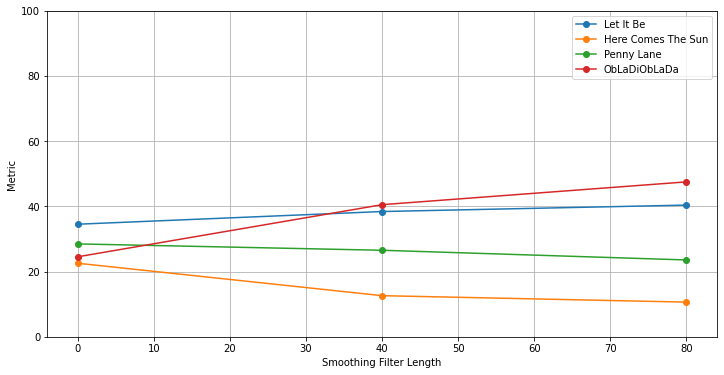

METRIC - DOWNSAMPLING CHANGE
Downsampling: [2, 4, 6]

Beatles_LetItBe : ['40.39', '39.37', '36.34']
Beatles_HereComesTheSun : ['11.62', '17.63', '19.63']
Beatles_PennyLane: ['13.57', '6.58', '16.56']
Beatles_ObLaDiObLaDa: ['54.47', '58.51', '59.49']


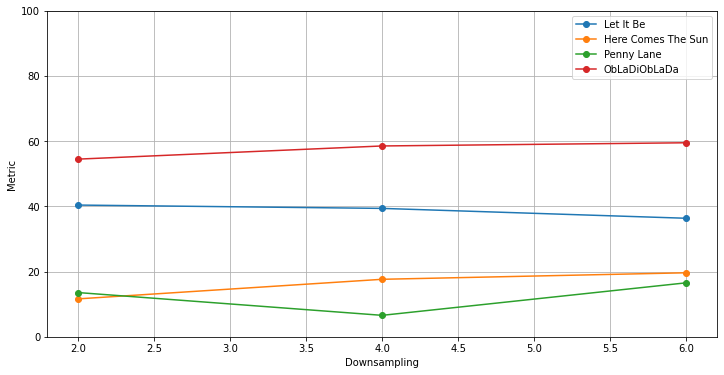

METRIC - HOP SIZE CHANGE
Hop size: [11025, 5512, 2756]

Beatles_LetItBe : ['39.52', '44.53', '45.52']
Beatles_HereComesTheSun : ['15.57', '17.56', '20.54']
Beatles_PennyLane: ['25.53', '29.52', '26.49']
Beatles_ObLaDiObLaDa: ['24.53', '29.51', '20.55']


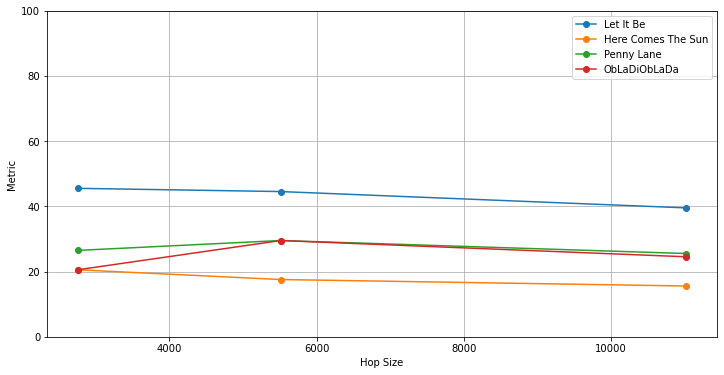

In [79]:
#Question 5

#MODIFY THE LENGTH OF THE SMOOTHING WINDOW

L = [0, 40, 80] #values of different lengths
D = 1 #downsampling initial value

print('METRIC - SMOOTH LENGTH CHANGE'+'\nSmoothing window lengths: ' + str(L) + '\n')

#LetItBe
metric1 = []
metric1Str = []
for i in range(len(L)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L[i], D)
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'), chordList_Wav)
    m=efficentAlg(chordList_Wav,Csv);
    metric1Str.append(str(m))
    metric1.append(m)
print('Beatles_LetItBe '+ ': ' + '\033[1m' + str(metric1Str) + '\033[0m')

#HereComesTheSun
metric2 = []
metric2Str = []
for i in range(len(L)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L[i], D)
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'), chordList_Wav)
    m2=efficentAlg(chordList_Wav,Csv);
    metric2Str.append(str(m2))
    metric2.append(m2)
print('Beatles_HereComesTheSun '+ ': ' + '\033[1m' + str(metric2Str) + '\033[0m')

#HereComesTheSun
metric3 = []
metric3Str = []
for i in range(len(L)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L[i], D)
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'), chordList_Wav)
    m3=efficentAlg(chordList_Wav,Csv);
    metric3Str.append(str(m3))
    metric3.append(m3)
print('Beatles_PennyLane' + ': ' + '\033[1m' + str(metric3Str) + '\033[0m')

#HereComesTheSun
metric4 = []
metric4Str = []
for i in range(len(L)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L[i], D)
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'), chordList_Wav)
    m4=efficentAlg(chordList_Wav,Csv);
    metric4Str.append(str(m4))
    metric4.append(m4)
print('Beatles_ObLaDiObLaDa' + ': ' + '\033[1m' + str(metric4Str) + '\033[0m')

#Plot 
plt.figure(figsize=(12,6))
plt.plot(L, metric1, marker='o', label = 'Let It Be')
plt.plot(L, metric2, marker='o', label = 'Here Comes The Sun')
plt.plot(L, metric3, marker='o', label = 'Penny Lane')
plt.plot(L, metric4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.grid()
plt.ylim([0,100])
plt.xlabel('Smoothing Filter Length')
plt.ylabel('Metric')
plt.show()

'---------------------------------------------------------------------------------------------------------------------'
#MODIFY THE DOWNSAMPLING VALUE

D = [2, 4, 6] #values of different downsampling
L = 100 #smoothing length initial value
print('\033[1m'+'METRIC - DOWNSAMPLING CHANGE'+ '\033[0m'+'\nDownsampling: ' + str(D) + '\n')

#LetItBe
metric1 = []
metric1Str = []
for i in range(len(D)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'), chordList_Wav)
    m=efficentAlg(chordList_Wav,Csv);
    metric1Str.append(str(m))
    metric1.append(m)
print('Beatles_LetItBe '+ ': ' + '\033[1m' + str(metric1Str) + '\033[0m')

#HereComesTheSun
metric2 = []
metric2Str = []
for i in range(len(D)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'), chordList_Wav)
    m2=efficentAlg(chordList_Wav,Csv);
    metric2Str.append(str(m2))
    metric2.append(m2)
print('Beatles_HereComesTheSun '+ ': ' + '\033[1m' + str(metric2Str) + '\033[0m')

#HereComesTheSun
metric3 = []
metric3Str = []
for i in range(len(D)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'), chordList_Wav)
    m3=efficentAlg(chordList_Wav,Csv);
    metric3Str.append(str(m3))
    metric3.append(m3)
print('Beatles_PennyLane' + ': ' + '\033[1m' + str(metric3Str) + '\033[0m')

#HereComesTheSun
metric4 = []
metric4Str = []
for i in range(len(D)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'), chordList_Wav)
    m4=efficentAlg(chordList_Wav,Csv);
    metric4Str.append(str(m4))
    metric4.append(m4)
print('Beatles_ObLaDiObLaDa' + ': ' + '\033[1m' + str(metric4Str) + '\033[0m')

#Plot 
plt.figure(figsize=(12,6))
plt.plot(D, metric1, marker='o', label = 'Let It Be')
plt.plot(D, metric2, marker='o', label = 'Here Comes The Sun')
plt.plot(D, metric3, marker='o', label = 'Penny Lane')
plt.plot(D, metric4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.grid()
plt.ylim([0,100])
plt.xlabel('Downsampling')
plt.ylabel('Metric')
plt.show()

'---------------------------------------------------------------------------------------------------------------------'
#MODIFY THE HOP SIZE

L = None #smoothing length initial value
D = None #downsampling initial value
Fs = 22050 #sampling frequency initial value
N = Fs #sample window lenght initial value
hop = [int(N/2),int(N/4),int(N/8)] #values of different hop size
print('\033[1m'+'METRIC - HOP SIZE CHANGE'+ '\033[0m'+'\nHop size: ' + str(hop) + '\n')

#LetItBe
metric1 = []
metric1Str = []
for i in range(len(hop)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_LetItBe.wav'), L, D,N,hop[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_LetItBe.csv'), chordList_Wav)
    m=efficentAlg(chordList_Wav,Csv);
    metric1Str.append(str(m))
    metric1.append(m)
print('Beatles_LetItBe '+ ': ' + '\033[1m' + str(metric1Str) + '\033[0m')

#HereComesTheSun
metric2 = []
metric2Str = []
for i in range(len(hop)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_HereComesTheSun.wav'), L, D, N,hop[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_HereComesTheSun.csv'), chordList_Wav)
    m2=efficentAlg(chordList_Wav,Csv);
    metric2Str.append(str(m2))
    metric2.append(m2)
print('Beatles_HereComesTheSun '+ ': ' + '\033[1m' + str(metric2Str) + '\033[0m')

#HereComesTheSun
metric3 = []
metric3Str = []
for i in range(len(hop)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_PennyLane.wav'), L, D,N,hop[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_PennyLane.csv'), chordList_Wav)
    m3=efficentAlg(chordList_Wav,Csv);
    metric3Str.append(str(m3))
    metric3.append(m3)
print('Beatles_PennyLane' + ': ' + '\033[1m' + str(metric3Str) + '\033[0m')

#HereComesTheSun
metric4 = []
metric4Str = []
for i in range(len(hop)):
    chordList_Wav, template_sequence, templates, Fs, N, H = template_based_chord_recognigtion(os.path.join('data','wav', 'Beatles_ObLaDiObLaDa.wav'), L, D,N,hop[i])
    Csv = chordsCsv(os.path.join('data','csv', 'Beatles_ObLaDiObLaDa.csv'), chordList_Wav)
    m4=efficentAlg(chordList_Wav,Csv);
    metric4Str.append(str(m4))
    metric4.append(m4)
print('Beatles_ObLaDiObLaDa' + ': ' + '\033[1m' + str(metric4Str) + '\033[0m')

#Plot 
plt.figure(figsize=(12,6))
plt.plot(hop, metric1, marker='o', label = 'Let It Be')
plt.plot(hop, metric2, marker='o', label = 'Here Comes The Sun')
plt.plot(hop, metric3, marker='o', label = 'Penny Lane')
plt.plot(hop, metric4, marker='o', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.grid()
plt.ylim([0,100])
plt.xlabel('Hop Size')
plt.ylabel('Metric')
plt.show()